## Pre requisites

In [1]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')

!pip install kaggle torchsummary
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces

import shutil
shutil.unpack_archive('140k-real-and-fake-faces.zip')

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:29<00:00, 157MB/s]
100% 3.75G/3.75G [00:29<00:00, 135MB/s]


In [1]:
import os
import numpy as np
import datetime
from copy import deepcopy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

### Parameters

In [2]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 10
BATCH_SIZE = 256
TRAIN_SUBSET_SIZE = 25000
LEARNING_RATE = 1e-4
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_CRITIC = 64
FEATURES_GEN = 64

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 2, 1, 0),  # img: 2x2
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
gen.to(device)
gen.load_state_dict(torch.load("models/generator.pth", weights_only=True))
gen.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

### Data loading

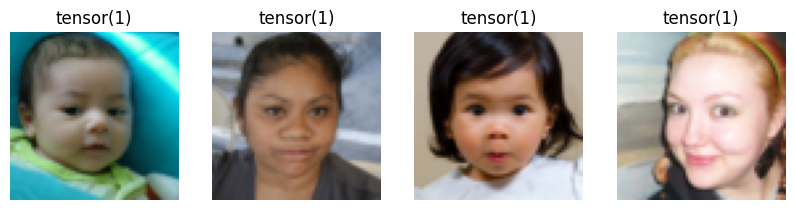

In [4]:
def create_dataloader(data_path, subset_size, batch_size, img_size, channels_img, class_label='real'):
    data_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * channels_img, [0.5] * channels_img),
    ])

    dataset = datasets.ImageFolder(root=data_path, transform=data_transforms)
    class_idx = dataset.class_to_idx[class_label]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    # subset_indices = random.sample(class_indices, subset_size)
    subset_indices = class_indices[:subset_size]
    subset_dataset = Subset(dataset, subset_indices)
    dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    return dataloader

train_loader = create_dataloader("real_vs_fake/real-vs-fake/train", TRAIN_SUBSET_SIZE, BATCH_SIZE, IMAGE_SIZE, CHANNELS_IMG)
valid_loader = create_dataloader("real_vs_fake/real-vs-fake/valid", 5000, 5000, IMAGE_SIZE, CHANNELS_IMG)
test_loader = create_dataloader("real_vs_fake/real-vs-fake/test", 5000, 5000, IMAGE_SIZE, CHANNELS_IMG)

for batch, labels in train_loader:
    img_count = 4
    images = batch[:img_count]
    images = (images + 1) / 2
    labels = labels[:img_count]
    plt.figure(figsize=(10, 4))
    for i in range(img_count):
      plt.subplot(1, img_count, i + 1)
      plt.imshow(images[i].permute(1,2,0))
      plt.title(labels[i])
      plt.axis("off")
    break

#### Generated data vectors

In [5]:
fixed_train_vector = torch.randn(len(train_loader),BATCH_SIZE, Z_DIM, 1, 1).to(device)
fixed_valid_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)
fixed_test_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)

## Critic re-training

### Modified discriminator architecture

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 16, 1, kernel_size=2, stride=1, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [ ]:
critic = Discriminator(3, 64)
critic.disc.add_module("7",nn.Flatten())
critic.disc.add_module("8",nn.Sigmoid())
critic.to(device)
critic.load_state_dict(torch.load("models/critic.pth", weights_only=True))
summary(critic, ( 3, 64, 64))

### Discriminator training loop

In [ ]:
optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
criterion = nn.BCELoss()
critic_train_losses = []
critic_valid_losses = []
epoch = 0
least_loss = np.inf

In [ ]:
for i in range(epoch, epoch + NUM_EPOCHS, 1):
    print(f"\nEPOCH [{i + 1}/{epoch + NUM_EPOCHS}] ", end=" ")
    critic.train()
    train_running_loss = 0.0

    # Training
    for batch_idx, (real_images, real_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = critic(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(fixed_train_vector[batch_idx]).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = critic(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    critic_train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    critic.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = critic(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = critic(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    critic_valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")

    if epoch_valid_loss < least_loss:
        least_loss = epoch_valid_loss
        os.makedirs("models", exist_ok=True)
        torch.save(deepcopy(critic.state_dict()), "models/critic_retrained.pth")
        print("INFO:Lowest validation Model saved")


EPOCH [1/10]  

100%|██████████| 97/97 [01:39<00:00,  1.02s/it]


Loss: 8.81931456339728 	Validation Loss: 2.6091344356536865	INFO:Lowest validation Model saved

EPOCH [2/10]  

100%|██████████| 97/97 [01:34<00:00,  1.03it/s]


Loss: 1.8328787334186514 	Validation Loss: 1.6072648763656616	INFO:Lowest validation Model saved

EPOCH [3/10]  

100%|██████████| 97/97 [01:33<00:00,  1.04it/s]


Loss: 1.1414893971583278 	Validation Loss: 0.34426653385162354	INFO:Lowest validation Model saved

EPOCH [4/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 0.793329090801711 	Validation Loss: 0.24256235361099243	INFO:Lowest validation Model saved

EPOCH [5/10]  

100%|██████████| 97/97 [01:37<00:00,  1.00s/it]


Loss: 0.6195673174464825 	Validation Loss: 0.12673038244247437	INFO:Lowest validation Model saved

EPOCH [6/10]  

100%|██████████| 97/97 [01:37<00:00,  1.01s/it]


Loss: 0.4912078363686493 	Validation Loss: 0.12592250108718872	INFO:Lowest validation Model saved

EPOCH [7/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 0.43948169905193074 	Validation Loss: 0.07598698139190674	INFO:Lowest validation Model saved

EPOCH [8/10]  

100%|██████████| 97/97 [01:37<00:00,  1.01s/it]


Loss: 0.34306376056803256 	Validation Loss: 0.05243312567472458	INFO:Lowest validation Model saved

EPOCH [9/10]  

100%|██████████| 97/97 [01:37<00:00,  1.00s/it]


Loss: 0.4748853682204313 	Validation Loss: 0.06421341001987457	
EPOCH [10/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 0.3311891858946033 	Validation Loss: 0.05573347210884094	

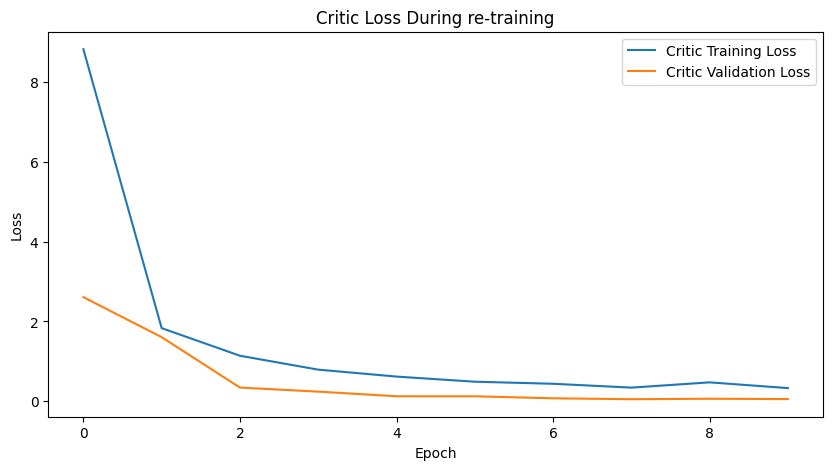

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(critic_train_losses, label="Critic Training Loss")
plt.plot(critic_valid_losses, label="Critic Validation Loss")
plt.title("Critic Loss During re-training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("Critic retraining.png")  # Save the loss plot

### Discriminator testing

In [ ]:
critic.eval()
correct = 0
total = 0
with torch.no_grad():
  for real_images, real_labels in test_loader:
    real_images, real_labels = real_images.to(device), real_labels.to(device).float()
    real_outputs = critic(real_images).squeeze()
    real_loss = criterion(real_outputs, real_labels)

    fake_images, fake_labels = gen(fixed_test_vector).to(device), torch.zeros_like(real_labels).to(device).float()
    fake_outputs = critic(fake_images).squeeze()
    fake_loss = criterion(fake_outputs, fake_labels)

    loss = real_loss + fake_loss
    outputs = real_outputs + fake_outputs
    labels = real_labels + fake_labels
    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy} Loss: {loss}')

Accuracy: 0.9986 Loss: 0.8312836289405823


## ResNet18

In [ ]:
from torchvision import models
torch.cuda.empty_cache()
resnet18 = models.resnet18(pretrained=True)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 value for binary classification
    nn.Sigmoid()  # Apply sigmoid activation to get probabilities
)
resnet18.to(device)
summary(resnet18, ( 3, 64, 64))

### Resnet18 training loop

In [ ]:
optimizer = optim.Adam(resnet18.parameters())
criterion = nn.BCELoss()
resnet18_train_losses = []
resnet18_valid_losses = []
epoch = 0
least_loss = np.inf

In [ ]:
for i in range(epoch, epoch + NUM_EPOCHS, 1):
    print(f"\nEPOCH [{i + 1}/{epoch + NUM_EPOCHS}] ", end=" ")
    resnet18.train()
    train_running_loss = 0.0
    # Training
    for batch_idx, (real_images, real_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = resnet18(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(fixed_train_vector[batch_idx]).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = resnet18(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    resnet18_train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    resnet18.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = resnet18(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = resnet18(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    resnet18_valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")


EPOCH [1/10]  

100%|██████████| 97/97 [01:33<00:00,  1.04it/s]


Loss: 0.303654800063556 	Validation Loss: 0.8902333974838257	
EPOCH [2/10]  

100%|██████████| 97/97 [01:19<00:00,  1.22it/s]


Loss: 0.0041081484373582085 	Validation Loss: 0.642520546913147	
EPOCH [3/10]  

100%|██████████| 97/97 [01:15<00:00,  1.28it/s]


Loss: 0.0016038925855026878 	Validation Loss: 0.5135162472724915	
EPOCH [4/10]  

100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Loss: 0.0008848987954198239 	Validation Loss: 0.5456835031509399	
EPOCH [5/10]  

100%|██████████| 97/97 [01:16<00:00,  1.26it/s]


Loss: 0.0007784073469085023 	Validation Loss: 0.5593985915184021	
EPOCH [6/10]  

100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Loss: 0.00045908684722272697 	Validation Loss: 0.5762295126914978	
EPOCH [7/10]  

100%|██████████| 97/97 [01:16<00:00,  1.26it/s]


Loss: 0.0003372577130650506 	Validation Loss: 0.5921504497528076	
EPOCH [8/10]  

100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


Loss: 0.00027289348621444644 	Validation Loss: 0.635441780090332	
EPOCH [9/10]  

100%|██████████| 97/97 [01:17<00:00,  1.26it/s]


Loss: 0.00022362273671909128 	Validation Loss: 0.5678198933601379	
EPOCH [10/10]  

100%|██████████| 97/97 [01:17<00:00,  1.25it/s]


Loss: 0.0001981194045865121 	Validation Loss: 0.626217782497406	

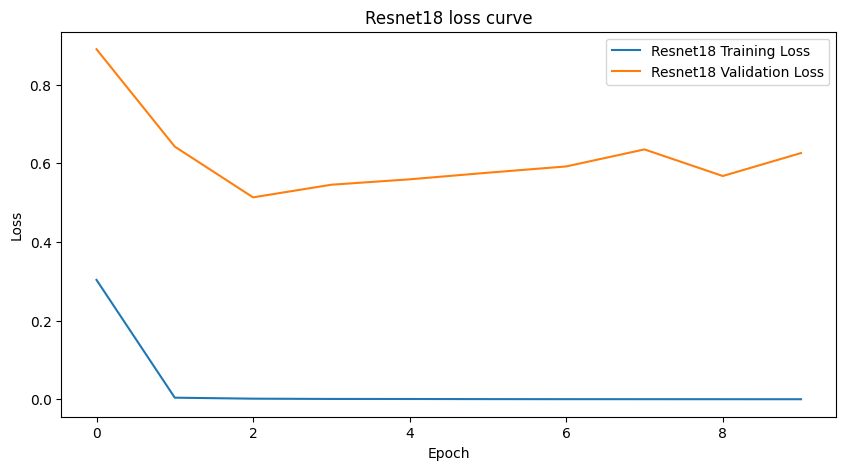

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(resnet18_train_losses, label="Resnet18 Training Loss")
plt.plot(resnet18_valid_losses, label="Resnet18 Validation Loss")
plt.title("Resnet18 loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("Resnet18 loss curve.png")  # Save the loss plot

### Resnet18 testing

In [ ]:
resnet18.eval()
correct = 0
total = 0
with torch.no_grad():
  for real_images, real_labels in test_loader:
    real_images, real_labels = real_images.to(device), real_labels.to(device).float()
    real_outputs = resnet18(real_images).squeeze()
    real_loss = criterion(real_outputs, real_labels)

    fake_images, fake_labels = gen(fixed_test_vector).to(device), torch.zeros_like(real_labels).to(device).float()
    fake_outputs = resnet18(fake_images).squeeze()
    fake_loss = criterion(fake_outputs, fake_labels)

    loss = real_loss + fake_loss
    outputs = real_outputs + fake_outputs
    labels = real_labels + fake_labels
    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy} Loss: {loss}')

Accuracy: 0.9998 Loss: 0.6243093013763428


## ResNet50

In [ ]:
from torchvision import models
torch.cuda.empty_cache()
resnet50 = models.resnet50(pretrained=True)
num_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 value for binary classification
    nn.Sigmoid()  # Apply sigmoid activation to get probabilities
)
resnet50.to(device)
summary(resnet50, ( 3, 64, 64))

### Resnet50 training loop

In [ ]:
optimizer = optim.Adam(resnet50.parameters())
criterion = nn.BCELoss()
resnet50_train_losses = []
resnet50_valid_losses = []
epoch = 0
least_loss = np.inf

In [ ]:
for i in range(epoch, epoch + NUM_EPOCHS, 1):
    print(f"\nEPOCH [{i + 1}/{epoch + NUM_EPOCHS}] ", end=" ")
    resnet50.train()
    train_running_loss = 0.0
    # Training
    for batch_idx, (real_images, real_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = resnet50(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(fixed_train_vector[batch_idx]).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = resnet50(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    resnet50_train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    resnet50.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = resnet50(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = resnet50(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    resnet50_valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")


EPOCH [1/10]  

100%|██████████| 97/97 [01:52<00:00,  1.16s/it]


Loss: 0.10157795592100773 	Validation Loss: 0.62895268201828	
EPOCH [2/10]  

100%|██████████| 97/97 [01:51<00:00,  1.15s/it]


Loss: 0.0007160341498542807 	Validation Loss: 0.5777701139450073	
EPOCH [3/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 0.0003246573461867754 	Validation Loss: 0.5573158860206604	
EPOCH [4/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 0.00018971624241700185 	Validation Loss: 0.5408457517623901	
EPOCH [5/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 0.00012691638523355106 	Validation Loss: 0.5508118271827698	
EPOCH [6/10]  

100%|██████████| 97/97 [01:51<00:00,  1.15s/it]


Loss: 9.10769376787357e-05 	Validation Loss: 0.5996930003166199	
EPOCH [7/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 8.413079449758126e-05 	Validation Loss: 0.5578948259353638	
EPOCH [8/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 5.8135973265905834e-05 	Validation Loss: 0.5632853507995605	
EPOCH [9/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 4.738132240875989e-05 	Validation Loss: 0.5789791345596313	
EPOCH [10/10]  

100%|██████████| 97/97 [01:50<00:00,  1.14s/it]


Loss: 3.820521988487111e-05 	Validation Loss: 0.6056482195854187	

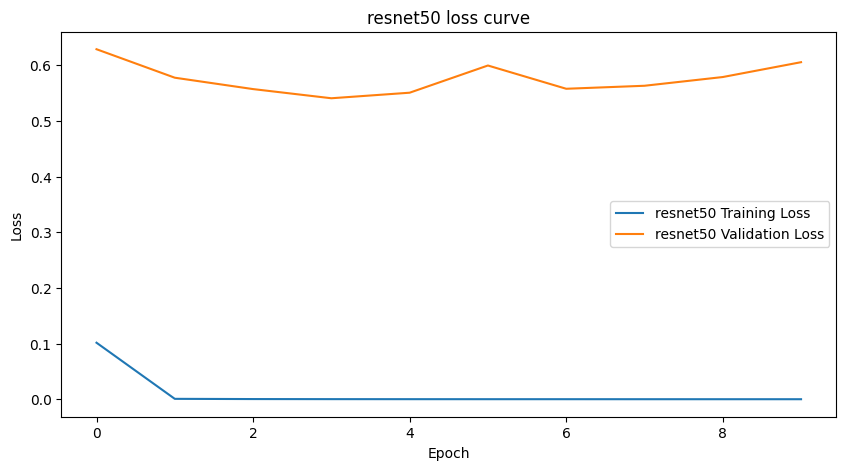

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(resnet50_train_losses, label="resnet50 Training Loss")
plt.plot(resnet50_valid_losses, label="resnet50 Validation Loss")
plt.title("resnet50 loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("resnet50 loss curve.png")  # Save the loss plot

### Resnet50 testing

In [ ]:
resnet50.eval()
correct = 0
total = 0
with torch.no_grad():
  for real_images, real_labels in test_loader:
    real_images, real_labels = real_images.to(device), real_labels.to(device).float()
    real_outputs = resnet50(real_images).squeeze()
    real_loss = criterion(real_outputs, real_labels)

    fake_images, fake_labels = gen(fixed_test_vector).to(device), torch.zeros_like(real_labels).to(device).float()
    fake_outputs = resnet50(fake_images).squeeze()
    fake_loss = criterion(fake_outputs, fake_labels)

    loss = real_loss + fake_loss
    outputs = real_outputs + fake_outputs
    labels = real_labels + fake_labels
    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy} Loss: {loss}')

Accuracy: 1.0 Loss: 0.6053034663200378


## VGGnet

In [9]:
from torchvision import models
torch.cuda.empty_cache()
vgg11 = models.vgg11(pretrained=True)
num_features = vgg11.classifier[-1].in_features
vgg11.classifier[-1] = nn.Sequential(
    nn.Linear(num_features, 1),  # Output 1 value for binary classification
    nn.Sigmoid()  # Apply sigmoid activation to get probabilities
)
vgg11.to(device)
summary(vgg11, ( 3, 64, 64))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
              ReLU-5          [-1, 128, 32, 32]               0
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Conv2d-7          [-1, 256, 16, 16]         295,168
              ReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         590,080
             ReLU-10          [-1, 256, 16, 16]               0
        MaxPool2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 8, 8]       1,180,160
             ReLU-13            [-1, 512, 8, 8]               0
           Conv2d-14            [-1, 51

### VGGnet training loop

In [10]:
optimizer = optim.Adam(vgg11.parameters())
criterion = nn.BCELoss()
vgg11_train_losses = []
vgg11_valid_losses = []
epoch = 0
least_loss = np.inf

In [11]:
for i in range(epoch, epoch + NUM_EPOCHS, 1):
    print(f"\nEPOCH [{i + 1}/{epoch + NUM_EPOCHS}] ", end=" ")
    vgg11.train()
    train_running_loss = 0.0
    # Training
    for batch_idx, (real_images, real_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        real_outputs = vgg11(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(real_outputs, real_labels)

        # On generator images
        fake_images = gen(fixed_train_vector[batch_idx]).to(device)
        fake_outputs = vgg11(fake_images).squeeze()
        # fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_loss = criterion(fake_outputs, torch.zeros_like(real_labels).float())

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    vgg11_train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    vgg11.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = vgg11(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = vgg11(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    vgg11_valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")
    del fake_images, fake_outputs, real_outputs
    torch.cuda.empty_cache()



EPOCH [1/10]  

100%|██████████| 97/97 [01:38<00:00,  1.01s/it]


Loss: 2.721945988763239 	Validation Loss: 1.3858704566955566	
EPOCH [2/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 1.5200428348226644 	Validation Loss: 1.386000633239746	
EPOCH [3/10]  

100%|██████████| 97/97 [01:37<00:00,  1.00s/it]


Loss: 1.4174967426614664 	Validation Loss: 1.2528424263000488	
EPOCH [4/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 0.26863924291240804 	Validation Loss: 0.00108487403485924	
EPOCH [5/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 0.008938038114002225 	Validation Loss: 0.0002293555880896747	
EPOCH [6/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 1.110734807154695 	Validation Loss: 1.3856335878372192	
EPOCH [7/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 2.278314464715953 	Validation Loss: 1.383307933807373	
EPOCH [8/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 1.3824789290575636 	Validation Loss: 1.3748884201049805	
EPOCH [9/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 0.9836472765993827 	Validation Loss: 0.02328331023454666	
EPOCH [10/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 0.023528755146007673 	Validation Loss: 0.0009363375138491392	

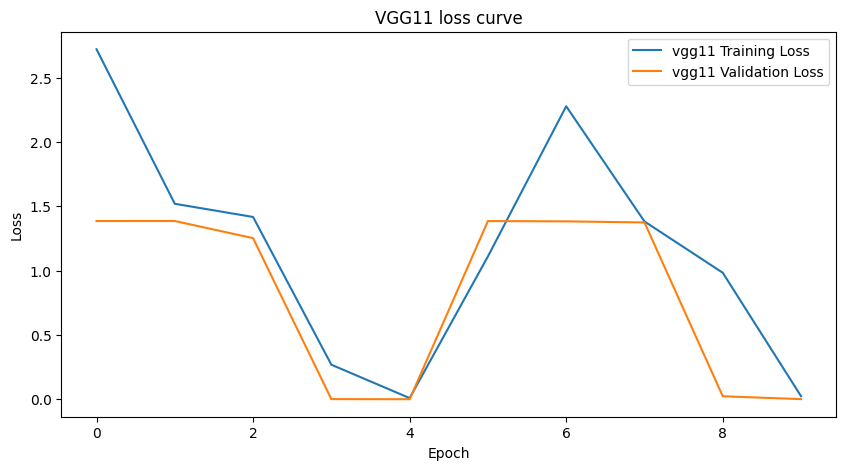

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(vgg11_train_losses, label="vgg11 Training Loss")
plt.plot(vgg11_valid_losses, label="vgg11 Validation Loss")
plt.title("VGG11 loss curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("vgg11 loss curve.png")  # Save the loss plot

### VGGnet testing

In [13]:
vgg11.eval()
correct = 0
total = 0
with torch.no_grad():
  for real_images, real_labels in test_loader:
    real_images, real_labels = real_images.to(device), real_labels.to(device).float()
    real_outputs = vgg11(real_images).squeeze()
    real_loss = criterion(real_outputs, real_labels)

    fake_images, fake_labels = gen(fixed_test_vector).to(device), torch.zeros_like(real_labels).to(device).float()
    fake_outputs = vgg11(fake_images).squeeze()
    fake_loss = criterion(fake_outputs, fake_labels)

    loss = real_loss + fake_loss
    outputs = real_outputs + fake_outputs
    labels = real_labels + fake_labels
    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy} Loss: {loss}')

Accuracy: 0.9994 Loss: 0.006350975017994642


## Results

In [14]:
critic_train_losses = [8.81931456339728,
1.8328787334186514,
1.1414893971583278,
0.793329090801711,
0.6195673174464825,
0.4912078363686493,
0.43948169905193074,
0.34306376056803256,
0.4748853682204313,
0.3311891858946033]

critic_valid_losses = [2.6091344356536865,
1.6072648763656616,
0.34426653385162354,
0.24256235361099243,
0.12673038244247437,
0.12592250108718872,
0.07598698139190674,
0.05243312567472458,
0.06421341001987457,
0.05573347210884094]

resnet18_train_losses = [0.303654800063556,
0.0041081484373582085,
0.0016038925855026878,
0.0008848987954198239,
0.0007784073469085023,
0.00045908684722272697,
0.0003372577130650506,
0.00027289348621444644,
0.00022362273671909128,
0.0001981194045865121]
resnet18_valid_losses = [0.8902333974838257,
0.642520546913147,
0.5135162472724915,
0.5456835031509399,
0.5593985915184021,
0.5762295126914978,
0.5921504497528076,
0.635441780090332,
0.5678198933601379,
0.626217782497406]

resnet50_train_losses = [0.10157795592100773,
0.0007160341498542807,
0.0003246573461867754,
0.00018971624241700185,
0.00012691638523355106,
9.10769376787357e-05,
8.413079449758126e-05,
5.8135973265905834e-05,
4.738132240875989e-05,
3.820521988487111e-05]
resnet50_valid_losses = [0.62895268201828,
0.5777701139450073,
0.5573158860206604,
0.5408457517623901,
0.5508118271827698,
0.5996930003166199,
0.5578948259353638,
0.5632853507995605,
0.5789791345596313,
0.6056482195854187]

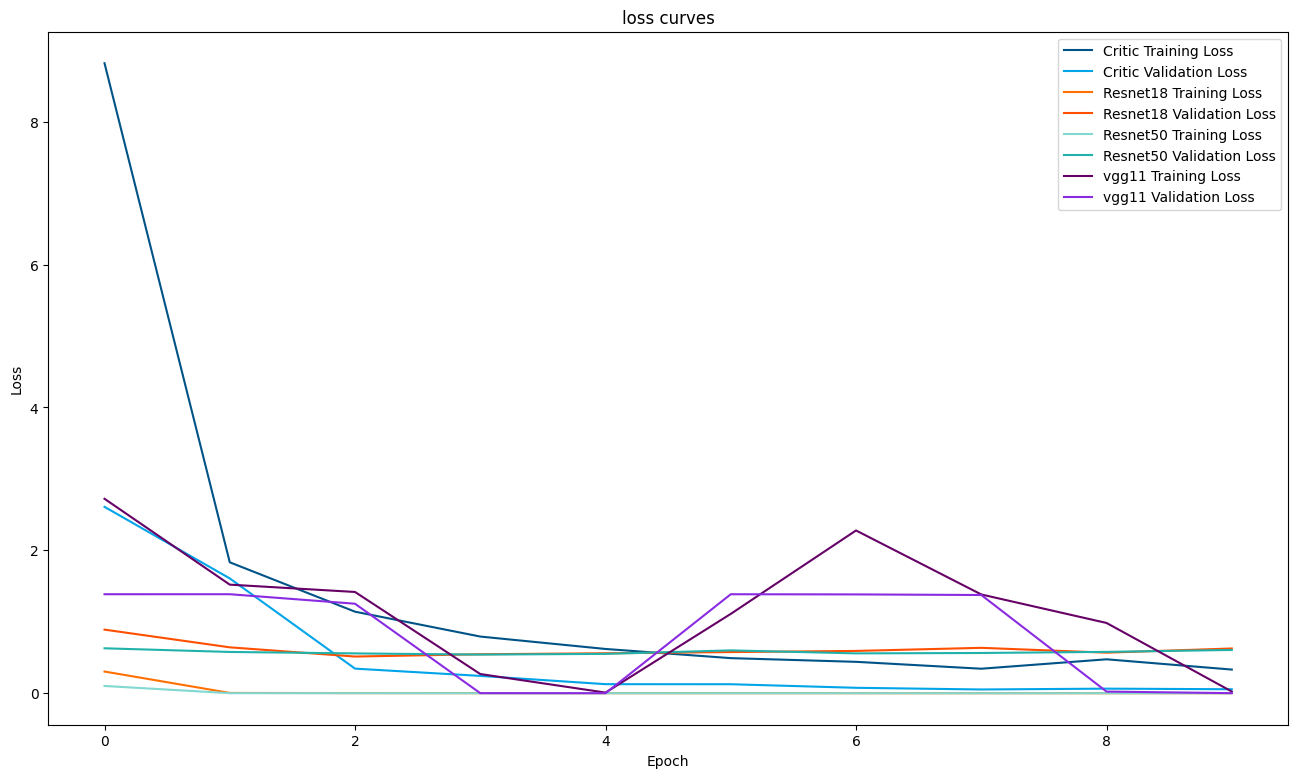

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(16, 9))
plt.plot(critic_train_losses, label="Critic Training Loss", color="#005387")
plt.plot(critic_valid_losses, label="Critic Validation Loss", color="#00a4e8")
plt.plot(resnet18_train_losses, label="Resnet18 Training Loss", color="#ff7000")
plt.plot(resnet18_valid_losses, label="Resnet18 Validation Loss", color="#ff4f00")
plt.plot(resnet50_train_losses, label="Resnet50 Training Loss", color="#81d8d0")
plt.plot(resnet50_valid_losses, label="Resnet50 Validation Loss", color="#20b2aa")
plt.plot(vgg11_train_losses, label="vgg11 Training Loss", color="#660066")
plt.plot(vgg11_valid_losses, label="vgg11 Validation Loss", color="#8a2be2")
plt.title("loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig("All models loss curve.png")  # Save the loss plot

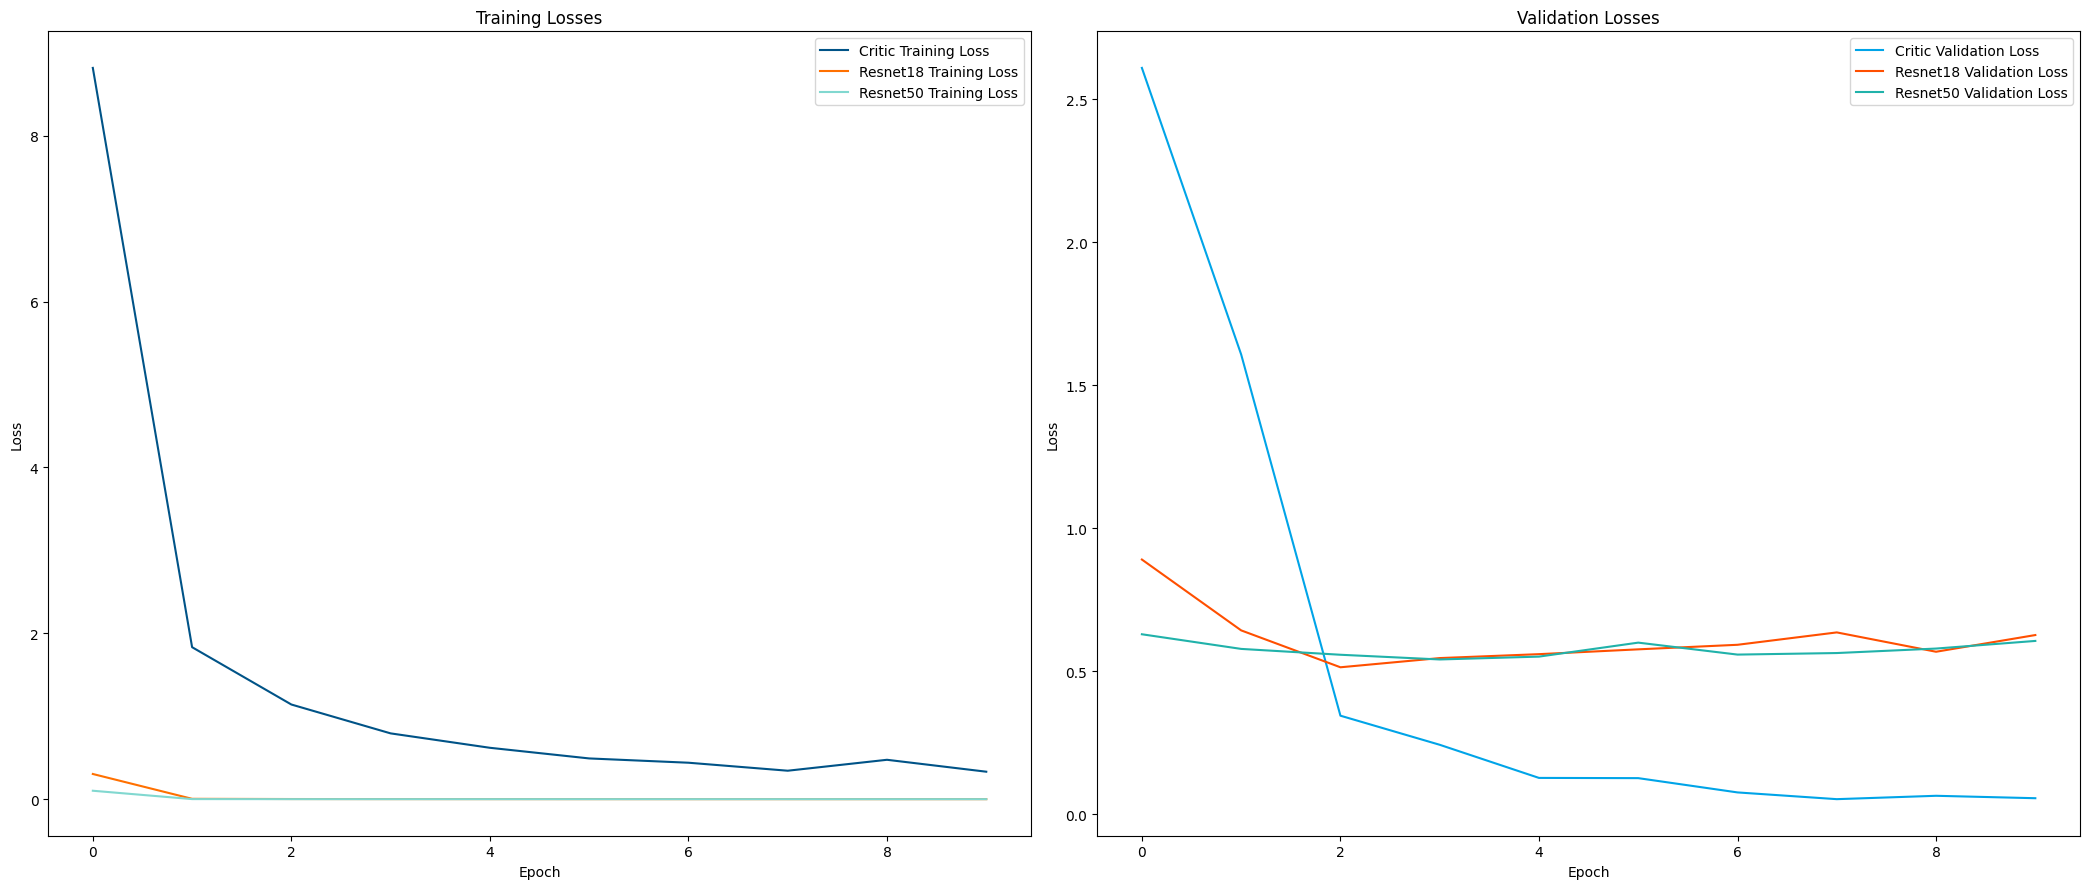

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(21, 9))

# Plot training losses
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(critic_train_losses, label="Critic Training Loss", color="#005387")
plt.plot(resnet18_train_losses, label="Resnet18 Training Loss", color="#ff7000")
plt.plot(resnet50_train_losses, label="Resnet50 Training Loss", color="#81d8d0")
# plt.plot(vgg11_train_losses, label="vgg11 Training Loss", color="#660066")
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot validation losses
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(critic_valid_losses, label="Critic Validation Loss", color="#00a4e8")
plt.plot(resnet18_valid_losses, label="Resnet18 Validation Loss", color="#ff4f00")
plt.plot(resnet50_valid_losses, label="Resnet50 Validation Loss", color="#20b2aa")
# plt.plot(vgg11_valid_losses, label="vgg11 Validation Loss", color="#8a2be2")
plt.title("Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

# Save the figure with both subplots
plt.savefig("Training_and_Validation_Loss_Curves.png")